In [1]:
import copy
import sys
sys.path.insert(0, "..")
from classes.atoms import Atom, Atom_Collection, create_atom_col_copies
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher
from classes.optimizers.md_simulator import MDTP_Simulator
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

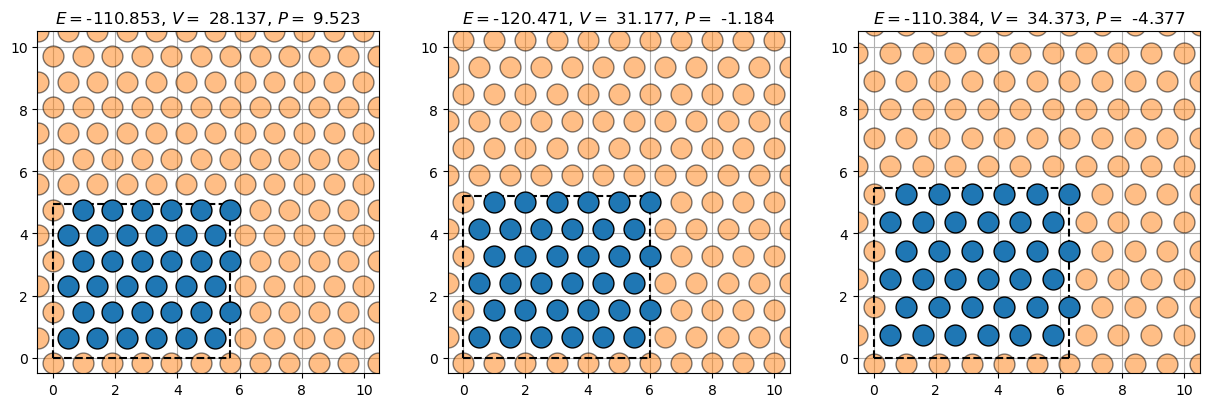

In [2]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

unit_cell = (np.array([2.0, 0.0]), np.cos(np.pi/6.0)*np.array([0.0,2.0]))
atom_poses = [np.array([0.0,0.0]), np.array([0.5,0.5]), np.array([1.0,0.0]), np.array([1.5,0.5])]
atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=30) for pos in atom_poses], unit_cell=unit_cell, pbc=True)
atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler) #Would like to fix this sometime
optimizer = Line_searcher(atom_col=atom_col)
pos_opt, f = optimizer.run(fmax=0.05)
opt_col = create_atom_col_copies(atom_col=atom_col, positions=pos_opt, velocities=np.zeros(shape=pos_opt.shape))[0]
l1, l2 = unit_cell
new_poses = []
for i in [0.0, 1.0, 2.0]:
    for j in [0.0, 1.0, 2.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([6.0, 0.0]), 3*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]
scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,10.5])
    ax.set_ylim([-0.5,10.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=20) for pos in np.array(new_poses).reshape(6**2, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_col.plot_cells(ax=ax, size=15)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)

In [60]:
def thermostat(atom_col, temp, kb=1.0):
        M, N = atom_col.velocities.shape
        current_vel = np.random.randn(M,N)*np.sqrt(kb*temp/atom_col.get_masses()[:,None])
        atom_col.set_velocities(current_vel)
    
def barostat(atom_col, target_stress=np.zeros(shape=(2,2)), step_size=1e-5, gamma=1e-3):
    max_scale = 5e-4
    min_scale = -5e-4
    current_stress = atom_col.get_stress_tensor(step_size=step_size)
    current_scale = (current_stress-target_stress)*gamma
    for i in range(len(current_scale)):
        if current_scale[i,i] > max_scale:
            current_scale[i,i] = max_scale
        if current_scale[i,i] < min_scale:
            current_scale[i,i] = min_scale
    atom_col.scale_volume(scale_x=current_scale[0,0], scale_y=current_scale[1,1])

def verlet_integrate(atom_col, time_step, N_steps=50):
        masses = atom_col.get_masses()
        for i in range(N_steps):
            acc = atom_col.get_forces()/masses[:,None]
            pos_step = atom_col.get_velocities()*time_step + 1.0/2.0*acc*time_step**2
            atom_col.set_positions(atom_col.get_positions()+pos_step)
            acc_new = atom_col.get_forces()/masses[:,None]
            step_velocities = 1.0/2.0*(acc + acc_new)*time_step
            atom_col.boost_velocities(step_velocities)

In [64]:
temps = [0.40, 0.45, 0.50, 0.55, 0.60, 0.60, 0.55, 0.50, 0.45, 0.40]
atom_col = copy.deepcopy(scaled_cols[1])
atom_cols_tracked = []
for temp in temps:
    atom_cols_for_temp = []
    for i in range(800):
        verlet_integrate(atom_col=atom_col, time_step=0.0001)
        thermostat(atom_col=atom_col, temp=temp)
        barostat(atom_col=atom_col, gamma=1e-4, step_size=1e-3)
        atom_cols_for_temp.append(copy.deepcopy(atom_col))
    atom_cols_tracked.append(atom_cols_for_temp)

In [65]:
volumes_mean = []
pressures_mean = []
energies_mean = []
for temp, atom_cols in zip(temps, atom_cols_tracked):
    volumes = []
    energies = []
    pressures = []
    for atom_coll in atom_cols:
        volumes.append(atom_coll.get_volume())
        pressures.append(atom_coll.get_pressure())
        energies.append(atom_coll.get_potential_energy())
    pressures_mean.append(np.mean(pressures[:-int(400/2)]))
    volumes_mean.append(np.mean(volumes[:-int(400/2)]))
    energies_mean.append(np.mean(energies[:-int(400/2)]))

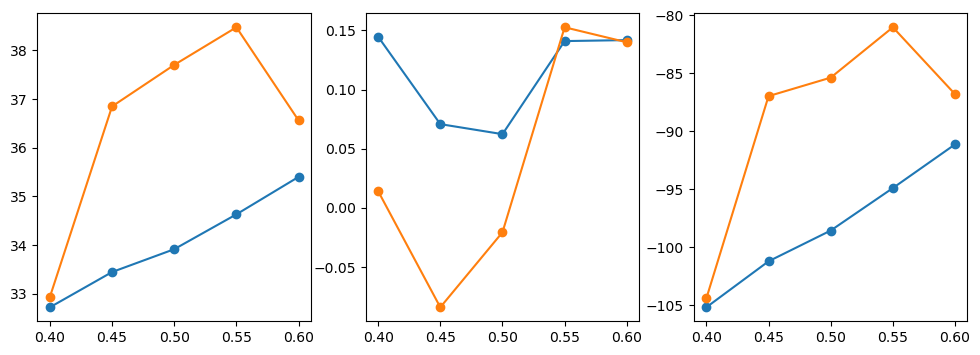

In [63]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(temps[0:5], volumes_mean[0:5],"o-", c="C0")
axs[1].plot(temps[0:5], pressures_mean[0:5], "o-", c="C0")
axs[2].plot(temps[0:5], energies_mean[0:5], "o-", c="C0")
axs[0].plot(temps[5:], volumes_mean[5:], "o-", c="C1")
axs[1].plot(temps[5:], pressures_mean[5:], "o-", c="C1")
axs[2].plot(temps[5:], energies_mean[5:], "o-", c="C1")

In [66]:
atom_col = copy.deepcopy(scaled_cols[1])
